In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from xgboost import XGBClassifier
from sklearn import metrics
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder, KBinsDiscretizer
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE



In [8]:
train_df = pd.read_csv("/home/ubuntu/try/file/preprocessed_train.csv")
test_df = pd.read_csv("/home/ubuntu/try/file/preprocessed_test.csv")
id_column = pd.read_csv('/home/ubuntu/try/file/train_predicted_missingvalues.csv')['id']
test_id= pd.read_csv('/home/ubuntu/try/file/test_predicted_missingvalues.csv')['id']
# 열 리스트(범주, 순서, 수치)
categorical_cols = ['Occupation','TypeofContact', 'Gender', 'Marital_Status']
ordinal_cols = ['ProductPitched', 'Designation']
numerical_cols = ['Age', 'CityTier', 'DurationOfPitch', 'NumberOfPersonVisiting', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'MonthlyIncome', 'Car_Ownership', 'Has_Children']

#순서형 변수 'Product Pitched' 와 'Designation'의 변수 순서
orders = [['basic','standard','deluxe','super deluxe','king'],
          ['vp','avp','executive','manager','senior manager']]

In [9]:
# 결측치 처리
# 수치형 - KNN Imputer
numerical_imputer = KNNImputer()
train_df[numerical_cols] = numerical_imputer.fit_transform(train_df[numerical_cols])
test_df[numerical_cols] = numerical_imputer.transform(test_df[numerical_cols])

# 범주, 순서형 - 최빈, 결측값은 근데 TypeOfContact에 6, 12개밖에 없음
# 범주형 - Simple Imputer
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols + ordinal_cols] = categorical_imputer.fit_transform(train_df[categorical_cols + ordinal_cols])
test_df[categorical_cols + ordinal_cols] = categorical_imputer.transform(test_df[categorical_cols + ordinal_cols])

In [10]:
# NumberOfFollowups 이상치 처리
#이상치 처리 클리핑 - 4보다 크면 4로 변경
train_df['NumberOfFollowups'] = train_df['NumberOfFollowups'].apply(lambda x: min(x, 4))
test_df['NumberOfFollowups'] = test_df['NumberOfFollowups'].apply(lambda x: min(x, 4))

# # NumberOfFollowups 이상치 처리 - 새로운 변수로 처리(1)
# # (75%)3분위수 값인 4보다 크면 1, 작으면 0
# X['NumberOfFollowups_outlier'] = X['NumberOfFollowups'].apply(lambda x: 1 if x > 4 else 0)
# test_df['NumberOfFollowups_outlier'] = test_df['NumberOfFollowups'].apply(lambda x: 1 if x > 4 else 0)

#MonthlyIncome 변수를 범주화 (KBinsDiscretizer)
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
train_df['Income_Category'] = kbins.fit_transform(train_df[['MonthlyIncome']])
test_df['Income_Category'] = kbins.transform(test_df[['MonthlyIncome']])

In [11]:
# 순서형 열과 범주형 열에 대해 Label Encoding, Ordinal Encoding 적용
for id, col in enumerate(ordinal_cols):
    oe = OrdinalEncoder(categories=[orders[id]])
    train_df[col] = oe.fit_transform(train_df[[col]].astype(str))
    test_df[col] = oe.fit_transform(test_df[[col]].astype(str))

for id, col in enumerate(categorical_cols):
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))
    test_df[col] = le.fit_transform(test_df[col].astype(str))

In [12]:
target = 'ProdTaken'
IDcol = 'id'

train_df['id']=id_column

# Feature와 Target 분리
y = train_df['ProdTaken']
train_df = train_df.drop(columns=['ProdTaken'])  # 'ProdTaken'을 Feature에서 제외

# SMOTE 적용
sm = SMOTE(random_state=42)
X_smote, y_smote = sm.fit_resample(train_df, y)

# SMOTE 적용 후 데이터 분포 확인
print('Original dataset shape:', y.value_counts())
print('Resampled dataset shape:', y_smote.value_counts())

# SMOTE 후 데이터를 DataFrame으로 변환 (X_smote와 y_smote를 하나로 합치기)
X_smote_df = pd.DataFrame(X_smote, columns=train_df.columns)
X_smote_df['ProdTaken'] = y_smote

Original dataset shape: ProdTaken
0    2992
1     497
Name: count, dtype: int64
Resampled dataset shape: ProdTaken
1    2992
0    2992
Name: count, dtype: int64


In [13]:

#모델구성 및 점수, 성능표 출력 함수
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['ProdTaken'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
        metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])

    alg.fit(dtrain[predictors], dtrain['ProdTaken'])

    # 학습
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:, 1]

    # 모델 점수 출력
    print("\nModel Report")
    print("AUC: %.4g" % metrics.roc_auc_score(dtrain['ProdTaken'].values, dtrain_predprob))


    # Confusion Matrix
    cm = confusion_matrix(dtrain['ProdTaken'], dtrain_predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Taken', 'Taken'], yticklabels=['Not Taken', 'Taken'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(dtrain['ProdTaken'], dtrain_predictions))

    # Feature Importance
    xgb.plot_importance(alg)
    plt.title('Feature Importance')
    plt.show()


Model Report
AUC: 0.9878


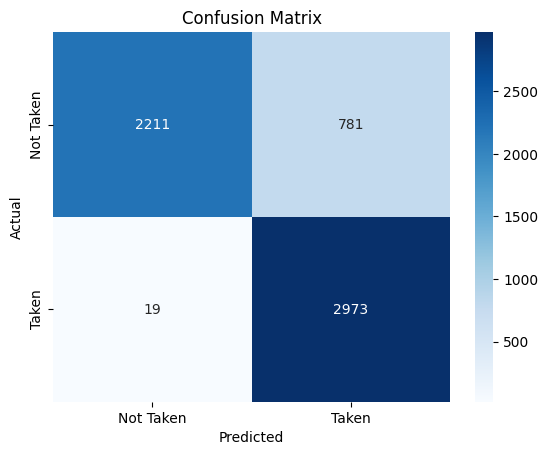

              precision    recall  f1-score   support

           0       0.99      0.74      0.85      2992
           1       0.79      0.99      0.88      2992

    accuracy                           0.87      5984
   macro avg       0.89      0.87      0.86      5984
weighted avg       0.89      0.87      0.86      5984



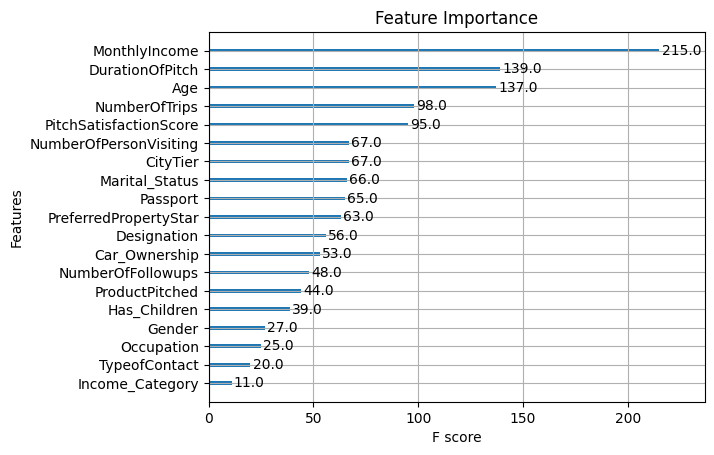

In [25]:
# Predictors 설정
predictors = [x for x in train_df.columns if x not in ['ProdTaken', IDcol]]

    # 모델 초기화
xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=3,
    min_child_weight=1,
    gamma=0.4,
    subsample=0.67,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    objective='binary:logistic',
    nthread=-1,
    scale_pos_weight=10,
    seed=27
)

# 모델 피팅
modelfit(xgb1,  X_smote_df, predictors)

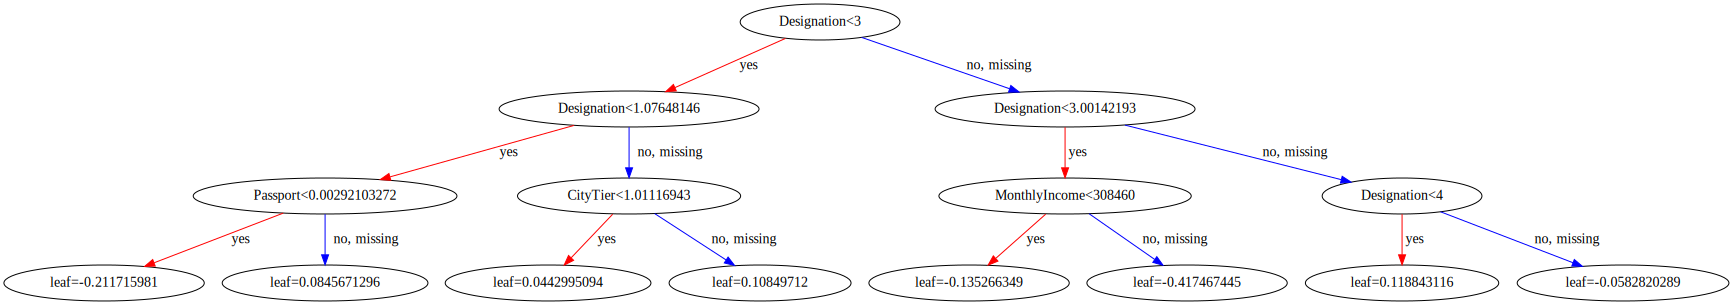

In [26]:
xgb.to_graphviz(xgb1)

In [30]:
pred= xgb1.predict_proba(test_df)
# 제출 파일 생성
submission_df = pd.DataFrame({
    'id': test_id,  # 테스트 데이터의 ID 열 사용
    'ProdTaken': pred[:, 1]  # 예약 확률
})

# 결과 CSV 파일로 저장
submission_df.to_csv('submission_ex1.csv', index=False,header=False)

In [27]:
test_df.head()

,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,NumberOfTrips,Passport,PitchSatisfactionScore,Designation,MonthlyIncome,Marital_Status,Car_Ownership,Has_Children,Income_Category
0,48.0,1,2.0,780.0,2,1,1.0,4.0,3.0,3.0,7.0,0.0,3.0,1.0,496950.0,3,0.0,0.0,4.0
1,30.0,1,2.0,720.0,2,0,1.0,4.0,1.0,3.0,4.0,1.0,3.0,4.0,300000.0,0,1.0,0.0,1.0
2,25.0,1,1.0,540.0,1,0,1.0,4.0,0.0,3.0,1.0,0.0,3.0,2.0,260000.0,1,0.0,0.0,0.0
3,21.0,0,2.0,420.0,1,1,1.0,4.0,0.0,4.0,1.0,0.0,3.0,4.0,259875.0,0,1.0,0.0,0.0
4,41.0,0,1.0,420.0,1,1,1.0,4.0,0.0,3.0,1.0,0.0,4.0,2.0,268830.0,2,1.0,0.0,0.0
